In [1]:
!pip install matplotlib seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.utils.spark_builder import get_spark_session

spark = get_spark_session("Jupyter Test")
print("!! SparkSession 생성 완료!")


25/09/17 03:35:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


!! SparkSession 생성 완료!


In [4]:
# Silver 데이터 로드
joined_path = "s3a://warehouse/silver/gdelt_events_detailed"
final_silver_df = spark.read.format("delta").load(joined_path)

print("✅ 데이터 로드 완료")
# print(f"총 레코드 수: {final_silver_df.count():,}")
print(f"컬럼 수: {len(final_silver_df.columns)}")

25/09/17 03:35:43 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


✅ 데이터 로드 완료
컬럼 수: 85


In [5]:
# 전체 컬럼 이름 출력
print("전체 컬럼 목록:")

# 스키마(타입 포함해서 보기)
final_silver_df.printSchema()

# 샘플 데이터 보기 (문자열 잘리지 않게)
final_silver_df.show(3, truncate=False)

# 세로로 한 행만 자세히 보기
final_silver_df.show(1, vertical=True)


전체 컬럼 목록:
root
 |-- global_event_id: long (nullable = true)
 |-- event_date: date (nullable = true)
 |-- actor1_code: string (nullable = true)
 |-- actor1_name: string (nullable = true)
 |-- actor1_country_code: string (nullable = true)
 |-- actor1_known_group_code: string (nullable = true)
 |-- actor1_ethnic_code: string (nullable = true)
 |-- actor1_religion1_code: string (nullable = true)
 |-- actor1_religion2_code: string (nullable = true)
 |-- actor1_type1_code: string (nullable = true)
 |-- actor1_type2_code: string (nullable = true)
 |-- actor1_type3_code: string (nullable = true)
 |-- actor2_code: string (nullable = true)
 |-- actor2_name: string (nullable = true)
 |-- actor2_country_code: string (nullable = true)
 |-- actor2_known_group_code: string (nullable = true)
 |-- actor2_ethnic_code: string (nullable = true)
 |-- actor2_religion1_code: string (nullable = true)
 |-- actor2_religion2_code: string (nullable = true)
 |-- actor2_type1_code: string (nullable = true)
 |-- act

25/09/17 03:35:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------+----------+------------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-----------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-------------+----------+---------------+---------------+----------+---------------+------------+-----------+------------+-----------------+---------------+-----------------------------------+-----------------------+--------------------+--------------------+--------------+---------------+---------------------+-------------------+------------------------------------------------------+---------------+-----------------+------------+-------------------+-----------------------------------------------------+-----------+------------------+------------------+------------------+-----------+----------+--

null 값

In [6]:
final_silver_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in final_silver_df.columns]).show()

+---------------+----------+-----------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-----------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-------------+----------+---------------+---------------+----------+---------------+------------+-----------+------------+--------+---------------+-------------------+-----------------------+--------------------+--------------------+--------------+---------------+---------------------+----------+----------+---------------+-----------------+------------+-------------------+------------------+-----------+------------------+------------------+------------------+-----------+----------+---------------+----------------+----------------------------+-------------+----+----------------------------+------

In [7]:
nulls = final_silver_df.select([
    (F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)) / F.count("*")).alias(c)
    for c in final_silver_df.columns
])
nulls.show(truncate=False)

+---------------+----------+------------------+------------------+-------------------+-----------------------+------------------+---------------------+---------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+------------------+-----------------+-------------+----------+---------------+---------------+----------+---------------+------------+-----------+------------+--------+---------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------+----------+---------------+-----------------+------------+-------------------+------------------+-----------+------------------+------------------+------------------+-----------+----------+---------------+----------------+----------------------------+-----------

In [8]:
# --------------------------------------------------
# 3. 수치형 컬럼 요약 통계
# --------------------------------------------------
numeric_cols = ["goldstein_scale", "avg_tone", "mention_doc_len", "mention_doc_tone", "confidence"]

final_silver_df.select([c for c in numeric_cols if c in final_silver_df.columns]) \
    .describe().show()

+-------+------------------+-------------------+------------------+-------------------+------------------+
|summary|   goldstein_scale|           avg_tone|   mention_doc_len|   mention_doc_tone|        confidence|
+-------+------------------+-------------------+------------------+-------------------+------------------+
|  count|              1181|               1181|              1181|               1181|              1181|
|   mean|0.7529212531752729|-1.7179928546608791| 5515.972904318374|-1.7178835074956318|42.167654530059274|
| stddev| 4.483219411266462|  3.854729533452844|4442.9509552537975| 3.8550054661522095| 30.21183408841037|
|    min|             -10.0|  -18.1818181818182|               148|  -18.1818181818182|                10|
|    max|              10.0|   10.7142857142858|             17841|   10.7142857142858|               100|
+-------+------------------+-------------------+------------------+-------------------+------------------+



In [9]:
# --------------------------------------------------
# 4. 범주형 컬럼 고유값
# --------------------------------------------------
categorical_cols = ["event_code", "event_root_code", "actor1_country_code", "actor2_country_code", "mention_source_name"]

for c in [c for c in categorical_cols if c in final_silver_df.columns]:
    print(f"\n✅ {c} Top 10")
    final_silver_df.groupBy(c).count().orderBy(F.desc("count")).show(10, truncate=False)



✅ event_code Top 10
+----------+-----+
|event_code|count|
+----------+-----+
|040       |122  |
|010       |105  |
|042       |86   |
|043       |85   |
|051       |74   |
|190       |55   |
|046       |53   |
|020       |52   |
|036       |52   |
|050       |37   |
+----------+-----+
only showing top 10 rows


✅ event_root_code Top 10
+---------------+-----+
|event_root_code|count|
+---------------+-----+
|04             |361  |
|01             |162  |
|05             |126  |
|03             |94   |
|19             |86   |
|02             |63   |
|11             |62   |
|07             |37   |
|17             |34   |
|12             |33   |
+---------------+-----+
only showing top 10 rows


✅ actor1_country_code Top 10
+-------------------+-----+
|actor1_country_code|count|
+-------------------+-----+
|null               |448  |
|USA                |254  |
|ISR                |43   |
|DEU                |31   |
|NZL                |30   |
|GBR                |27   |
|CHN             

In [10]:
# --------------------------------------------------
# 5. 날짜 분포
# --------------------------------------------------
if "event_date" in final_silver_df.columns:
    final_silver_df.groupBy("event_date").count().orderBy("event_date").show(5)

if "mention_time_date" in final_silver_df.columns:
    final_silver_df.groupBy("mention_time_date").count().orderBy("mention_time_date").show(5)

+----------+-----+
|event_date|count|
+----------+-----+
|2024-09-16|    4|
|2025-09-09|    5|
|2025-09-16| 1172|
+----------+-----+

+-----------------+-----+
|mention_time_date|count|
+-----------------+-----+
|   20250916024500| 1181|
+-----------------+-----+



In [11]:
# --------------------------------------------------
# 7. 태그 필드 구조
# --------------------------------------------------
text_cols = ["themes", "persons", "organizations", "locations"]

for col in [c for c in text_cols if c in final_silver_df.columns]:
    print(f"\n✅ {col} 분포")
    final_silver_df.select(
        F.size(F.split(F.col(col), ";")).alias(f"{col}_count")
    ).summary().show()


✅ themes 분포


+-------+-----------------+
|summary|     themes_count|
+-------+-----------------+
|  count|             1181|
|   mean|55.75867908552075|
| stddev|34.56075740130723|
|    min|               -1|
|    25%|               34|
|    50%|               53|
|    75%|               68|
|    max|              142|
+-------+-----------------+


✅ persons 분포
+-------+-----------------+
|summary|    persons_count|
+-------+-----------------+
|  count|             1181|
|   mean|  8.8848433530906|
| stddev|8.980408935991962|
|    min|               -1|
|    25%|                4|
|    50%|                6|
|    75%|               10|
|    max|               46|
+-------+-----------------+


✅ organizations 분포
+-------+-------------------+
|summary|organizations_count|
+-------+-------------------+
|  count|               1181|
|   mean|  5.878916172734971|
| stddev|  6.379235715651865|
|    min|                 -1|
|    25%|                  2|
|    50%|                  4|
|    75%|             

In [12]:
# --------------------------------------------------
# 8. 출처별 기사 요약
# --------------------------------------------------
if "mention_source_name" in final_silver_df.columns:
    final_silver_df.groupBy("mention_source_name").agg(
        F.count("*").alias("mentions"),
        F.avg("mention_doc_tone").alias("avg_tone")
    ).orderBy(F.desc("mentions")).show(10, truncate=False)

+-------------------+--------+--------------------+
|mention_source_name|mentions|avg_tone            |
+-------------------+--------+--------------------+
|thenews.com.pk     |77      |-2.391149179157746  |
|citywatchla.com    |71      |-2.7743380265572237 |
|en.people.cn       |56      |0.3514976120695761  |
|en.vietnamplus.vn  |45      |5.190087493968277   |
|hindustantimes.com |44      |-4.639511585467378  |
|nzherald.co.nz     |38      |-4.530744336569579  |
|links.org.au       |37      |-0.24354603019970986|
|brnow.org          |36      |1.5336043774564156  |
|irishdentist.ie    |34      |-3.9044683319204743 |
|religionnews.com   |34      |0.07246376811594012 |
+-------------------+--------+--------------------+
only showing top 10 rows



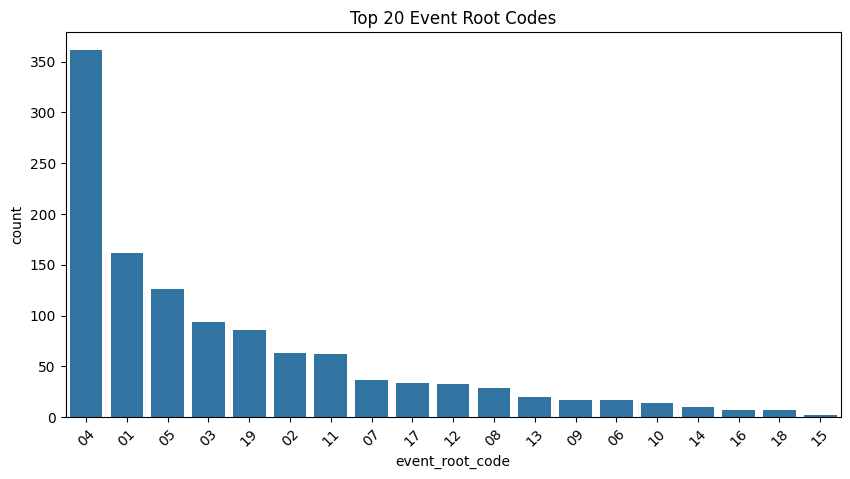

In [13]:
# 사건 코드별 분포
event_dist = (
    final_silver_df.groupBy("event_root_code")
      .count()
      .orderBy(F.desc("count"))
      .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(x="event_root_code", y="count", data=event_dist.head(20))
plt.title("Top 20 Event Root Codes")
plt.xticks(rotation=45)
plt.show()

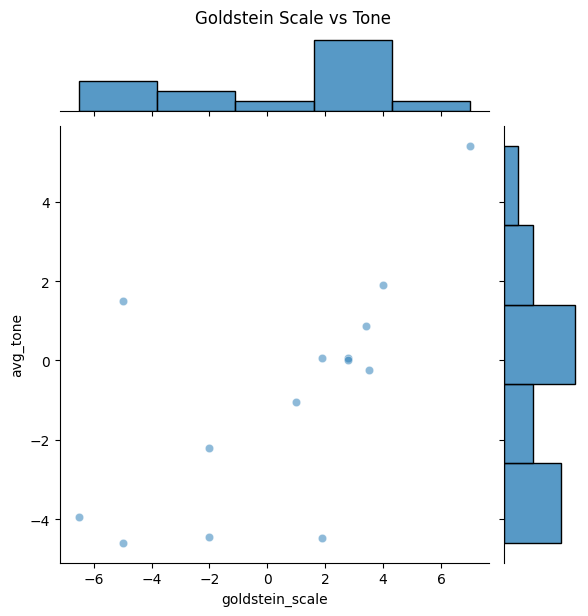

In [14]:
# Goldstein Scale & Tone 분포
meta_pd = final_silver_df.select("goldstein_scale", "avg_tone").sample(False, 0.01).toPandas()
sns.jointplot(x="goldstein_scale", y="avg_tone", data=meta_pd, alpha=0.5)
plt.suptitle("Goldstein Scale vs Tone", y=1.02)
plt.show()

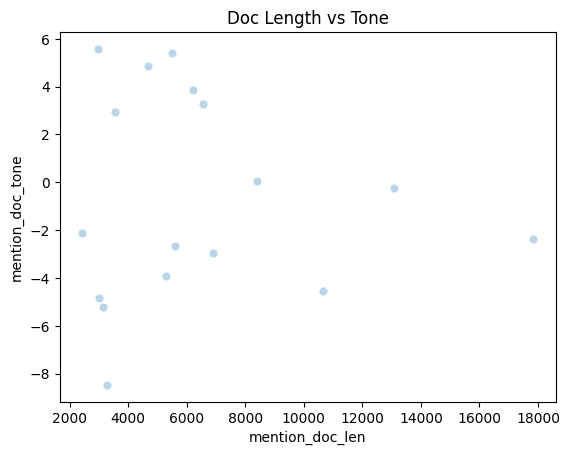

            mention_source_name  mention_doc_tone
13               thestar.com.my          5.580357
2             en.vietnamplus.vn          5.128854
1                  en.people.cn          3.875969
14                   vocalo.org          3.285968
0   communitynewspapergroup.com          2.922078
11             religionnews.com          0.072464
6                  links.org.au         -0.243546
12               thenews.com.pk         -2.391149
8              newstalkzb.co.nz         -2.392307
7              naija247news.com         -2.944269


In [15]:
# --------------------------------------------------
# 3. Mention 메타데이터 EDA
# --------------------------------------------------
mention_pd = (
    final_silver_df.select("mention_source_name", "mention_doc_len", "mention_doc_tone", "confidence")
      .sample(False, 0.01)
      .toPandas()
)

# 기사 길이 vs 톤
sns.scatterplot(x="mention_doc_len", y="mention_doc_tone", alpha=0.3, data=mention_pd)
plt.title("Doc Length vs Tone")
plt.show()

# 소스별 평균 톤
src_tone = (
    mention_pd.groupby("mention_source_name")["mention_doc_tone"]
    .mean()
    .reset_index()
    .sort_values("mention_doc_tone", ascending=False)
)
print(src_tone.head(10))

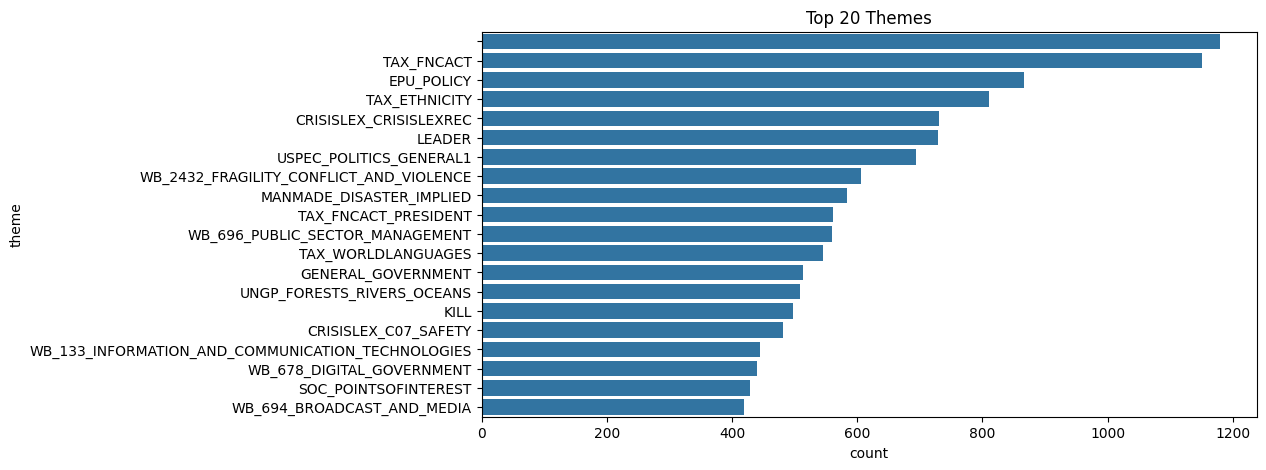

In [16]:
# --------------------------------------------------
# 4. GKG 태그 분석
# --------------------------------------------------
# Themes 상위 빈도
themes = (
    final_silver_df.select(F.explode(F.split("themes", ";")).alias("theme"))
      .groupBy("theme").count()
      .orderBy(F.desc("count"))
      .limit(20)
      .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(y="theme", x="count", data=themes)
plt.title("Top 20 Themes")
plt.show()

In [17]:
# 인물 / 조직 태그 (persons, organizations)
persons = (
    final_silver_df.select(F.explode(F.split("persons", ";")).alias("person"))
      .groupBy("person").count()
      .orderBy(F.desc("count"))
      .limit(20)
      .toPandas()
)
print("Top Persons:\n", persons)

Top Persons:
                            person  count
0      Abdel Fattah El Sisi,14410     77
1               Donald Trump,4769     77
2          Masoud Pezeshkian,5127     77
3         Benjamin Netanyahu,4751     77
4            Shehbaz Sharif,12175     77
5                   Hamad Al,9711     77
6               Sheikh Tamim,9698     77
7   Marshal Syed Asim Munir,12471     77
8   Jasem Mohamed Al-Budaiwi,3803     77
9                Tayyip Erdo,6322     77
10   Mohammed Shia Al-Sudani,5174     77
11      Abdel Fattah El-Sisi,5540     77
12              Sheikh Tamim,6599     77
13            Tayyip Erdogan,5215     77
14              Sheikh Tamim,7640     77
15            Shehbaz Sharif,8362     77
16       Muhammad Ishaq Dar,12439     77
17                  Hamad Al,6612     77
18              Donald Trump,4492     77
19              Marco Rubio,15544     77


In [18]:
# --------------------------------------------------
# 5. 멀티미디어/소셜 메타
# --------------------------------------------------
media_stats = final_silver_df.select(
    F.count(F.when(F.col("sharing_image").isNotNull(), 1)).alias("image_count"),
    F.count(F.when(F.col("social_video_embeds").isNotNull(), 1)).alias("video_count")
).toPandas()

print(media_stats)

   image_count  video_count
0          196          460


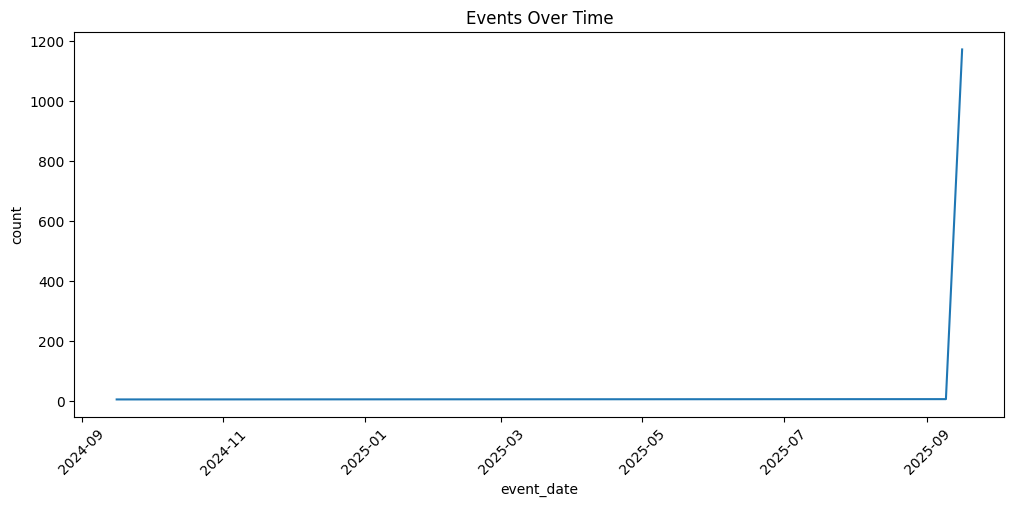

In [19]:
# --------------------------------------------------
# 6. 시계열 분석
# --------------------------------------------------
# 일자별 이벤트 수
time_series = (
    final_silver_df.groupBy("event_date")
      .count()
      .orderBy("event_date")
      .toPandas()
)

plt.figure(figsize=(12,5))
sns.lineplot(x="event_date", y="count", data=time_series)
plt.title("Events Over Time")
plt.xticks(rotation=45)
plt.show()

In [20]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# ✅ CAMEO Event Code → 한국어 설명 매핑
CAMEO_EVENT_MAP_KO = {
    "010": "공식 성명을 발표했다 (issued a public statement)",
    "020": "긴급 호소를 했다 (made an urgent appeal)",
    "030": "협력 의지를 강력히 표명했다 (expressed strong intent to cooperate with)",
    "040": "협의를 가졌다 (held consultations with)",
    "050": "외교적 협력을 했다 (engaged in diplomatic cooperation with)",
    "060": "물질적 지원을 제공했다 (provided material cooperation to)",
    "070": "원조를 확대했다 (extended aid to)",
    "080": "요구에 굴복했다 (yielded to demands from)",
    "090": "조사를 시작했다 (launched an investigation into)",
    "100": "요구사항을 제기했다 (made demands to)",
    "110": "불만을 표명했다 (voiced disapproval of)",
    "120": "제안을 거부했다 (rejected proposals from)",
    "130": "위협을 가했다 (issued threats against)",
    "140": "시위를 조직했다 (organized protests against)",
    "150": "군사력을 시위했다 (demonstrated military force against)",
    "160": "관계를 단절했다 (severed relations with)",
    "170": "강압을 가했다 (applied coercion to)",
    "180": "공격을 개시했다 (launched assault on)",
    "190": "무력 충돌을 벌였다 (engaged in armed conflict with)",
    "200": "대규모 폭력을 자행했다 (perpetrated mass violence against)",
}

# ✅ Python 함수 정의 (한국어 버전)
def summarize_event_udf(event_date, actor1, actor2, location, event_code, tone, goldstein, source):
    a1 = actor1 if actor1 else "Unknown Actor1"
    a2 = actor2 if actor2 else "Unknown Actor2"
    label = CAMEO_EVENT_MAP_KO.get(event_code, f"Event code {event_code}")
    loc = location if location else "Unknown location"
    src = source if source else "Unknown source"
    tone_str = f"{tone:.2f}" if tone is not None else "N/A"
    goldstein_str = f"{goldstein:.1f}" if goldstein is not None else "N/A"

    return f"{event_date}에 {a1}이(가) {a2}와 관련하여 {loc}에서 {label}. 기사 출처는 {src}이며, 평균 톤은 {tone_str}, 사건 영향도(Goldstein)는 {goldstein_str}이다."

# ✅ PySpark UDF 등록
summarize_event = F.udf(summarize_event_udf, StringType())

# ✅ 새로운 요약 컬럼 추가
final_silver_df = final_silver_df.withColumn(
    "event_summary",
    summarize_event(
        F.col("event_date"),
        F.col("actor1_name"),
        F.col("actor2_name"),
        F.col("action_geo_fullname"),
        F.col("event_code"),
        F.col("avg_tone"),
        F.col("goldstein_scale"),
        F.col("mention_source_name")
    )
)

# ✅ 샘플 확인
final_silver_df.select("global_event_id", "event_summary").show(5, truncate=False)


+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|global_event_id|event_summary                                                                                                                                                                       |
+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1263346265     |2025-09-16에 ARAB LEAGUE이(가) QATAR와 관련하여 Doha, Ad Daw?ah, Qatar에서 Event code 044. 기사 출처는 en.people.cn이며, 평균 톤은 -2.91, 사건 영향도(Goldstein)는 2.5이다.         |
|1263346264     |2025-09-16에 ARAB LEAGUE이(가) QATAR와 관련하여 Doha, Ad Daw?ah, Qatar에서 Event code 044. 기사 출처는 en.people.cn이며, 평균 톤은 -2.91, 사건 영향도(Goldstein)는 2.5이다.         |
|1263346437     |2025-09-16에 ISLAMIC이(가) QATAR와 관련하여 Jerusalem,

In [21]:
# --------------------------------------------------
# 📌 GDELT Themes 매핑 & 요약 처리 코드
# --------------------------------------------------

from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from collections import Counter

# ✅ 1. themes 접두어 매핑 사전 정의
theme_mapping = {
    "WB_": "세계은행 주제 (World Bank theme)",
    "ECON_": "경제 (economic)",
    "TAX_": "세금 (taxation)",
    "TRADE": "무역 (trade)",
    "CRISISLEX_": "위기 (crisis)",
    "NATURAL_DISASTER_": "자연재해 (natural disaster)",
    "FNCACT": "금융 활동 (financial activities)",
    "EPU_": "경제정책 불확실성 (economic policy uncertainty)",
    "SANCTIONS": "제재 (sanctions)",
    "AID_": "원조/인도주의 지원 (aid/humanitarian)",
    "UNREST_": "사회 불안/저항 (unrest)",
    "TERROR": "테러 관련 (terrorism)",
    "CONFLICT": "분쟁/갈등 (conflict)",
    "HUMAN_RIGHTS": "인권 (human rights)",
    "MEDIA": "미디어/언론 (media)",
    "DISASTER": "재해 (disaster)"
    # 필요시 계속 확장
}

# ✅ 2. themes 문자열을 요약하는 함수
def summarize_themes(themes: str) -> str:
    if not themes:
        return ""
    counter = Counter()
    for t in themes.split(";"):
        matched = False
        for key, val in theme_mapping.items():
            if t.startswith(key):
                counter[val.strip()] += 1
                matched = True
                break
        if not matched:
            counter["기타"] += 1
    # 상위 5개 카테고리만 요약
    return ", ".join([f"{k}({v})" for k, v in counter.most_common(5)])

# ✅ 3. PySpark UDF 등록
summarize_themes_udf = F.udf(summarize_themes, StringType())

# ✅ 4. 원본 themes → themes_summary 추가
final_silver_df = final_silver_df.withColumn(
    "themes_summary", summarize_themes_udf(F.col("themes"))
)

# ✅ 5. 확인용 출력
final_silver_df.select("themes_summary", "themes").show(10, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
# --------------------------------------------------
# 📌 GDELT 문맥 태그 매핑 & 요약 처리 코드
# --------------------------------------------------

from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from collections import Counter

# ✅ 1. themes 접두어 매핑 사전 정의
theme_mapping = {
    # 국제기구/정책 관련
    "WB_": "세계은행 주제 (World Bank theme)",
    "UN_": "유엔 관련 (United Nations)",
    "EU_": "유럽연합 관련 (European Union)",

    # 경제/재정
    "ECON_": "경제 (economic)",
    "EPU_": "경제정책 불확실성 (economic policy uncertainty)",
    "FINANCE": "금융/재정 (finance)",
    "FNCACT": "금융 활동 (financial activities)",
    "TAX_": "세금 (taxation)",
    "TRADE": "무역 (trade)",
    "INVEST": "투자 (investment)",
    "SANCTIONS": "제재 (sanctions)",

    # 사회/정치 불안
    "UNREST_": "사회 불안/저항 (unrest)",
    "PROTEST": "시위/항의 (protest)",
    "STRIKE": "파업/노동쟁의 (strike)",
    "COUP": "쿠데타 (coup d'état)",

    # 갈등/안보
    "CONFLICT": "분쟁/갈등 (conflict)",
    "MILITARY": "군사 관련 (military)",
    "SECURITY": "안보/방위 (security)",
    "TERROR": "테러 관련 (terrorism)",
    "VIOLENCE": "폭력 사건 (violence)",
    "WAR": "전쟁 (war)",

    # 인권/법치
    "HUMAN_RIGHTS": "인권 (human rights)",
    "GENOCIDE": "집단학살 (genocide)",
    "JUSTICE": "사법/정의 (justice)",
    "LAW": "법률/규제 (law)",
    "SOVEREIGNTY": "주권 문제 (sovereignty)",

    # 재난/위기
    "CRISISLEX_": "위기 (crisis)",
    "NATURAL_DISASTER_": "자연재해 (natural disaster)",
    "DISASTER": "재해 (disaster)",
    "FLOOD": "홍수 (flood)",
    "EARTHQUAKE": "지진 (earthquake)",
    "FIRE": "화재 (fire)",
    "EPIDEMIC": "전염병/질병 확산 (epidemic)",

    # 원조/구호
    "AID_": "원조/인도주의 지원 (aid/humanitarian)",
    "FOOD_SECURITY": "식량 안보 (food security)",
    "REFUGEE": "난민/이주민 (refugees/migration)",
    "HUMANITARIAN": "인도주의 (humanitarian aid)",

    # 환경/자원
    "CLIMATE": "기후/환경 (climate/environment)",
    "ENERGY": "에너지 (energy)",
    "OIL": "석유/가스 (oil/gas)",
    "WATER": "물 자원 (water resources)",
    "FOREST": "산림/자연자원 (forests/natural resources)",

    # 미디어/정보
    "MEDIA": "미디어/언론 (media)",
    "INTERNET": "인터넷/디지털 (internet/digital)",
    "ICT": "정보통신기술 (ICT)",
    "SOCIAL_MEDIA": "소셜 미디어 (social media)",

    # 기타
    "ELECTION": "선거/정치 과정 (elections)",
    "CORRUPTION": "부패 (corruption)",
    "TRANSPARENCY": "투명성 (transparency)",
    "CRIME": "범죄 (crime)",
    "DRUG": "마약/불법거래 (drugs/illicit trade)",
    "ORGANIZED_CRIME": "조직범죄 (organized crime)",
}


# ✅ 2. themes 요약 함수
def summarize_themes(themes: str) -> str:
    if not themes:
        return ""
    counter = Counter()
    for t in themes.split(";"):
        matched = False
        for key, val in theme_mapping.items():
            if t.startswith(key):
                counter[val.strip()] += 1
                matched = True
                break
        if not matched:
            counter["기타"] += 1
    return ", ".join([f"{k}({v})" for k, v in counter.most_common(5)])

# ✅ 3. persons/orgs/locs 요약 함수
def summarize_entities(tag_str: str, topn: int = 5) -> str:
    if not tag_str:
        return ""
    # GDELT는 "이름,빈도;이름,빈도;..." 형식
    entities = []
    for t in tag_str.split(";"):
        parts = t.split(",")
        if len(parts) >= 2:
            name, freq = parts[0].strip(), parts[1].strip()
            try:
                freq = int(freq)
            except:
                freq = 1
            entities.append((name, freq))
        else:
            entities.append((t.strip(), 1))
    counter = Counter(dict(entities))
    return ", ".join([f"{k}({v})" for k, v in counter.most_common(topn)])

# ✅ 4. PySpark UDF 등록
summarize_themes_udf = F.udf(summarize_themes, StringType())
summarize_entities_udf = F.udf(summarize_entities, StringType())

# ✅ 5. 새로운 컬럼 생성
final_silver_df = (
    final_silver_df
    .withColumn("themes_summary", summarize_themes_udf(F.col("themes")))
    .withColumn("persons_summary", summarize_entities_udf(F.col("persons")))
    .withColumn("organizations_summary", summarize_entities_udf(F.col("organizations")))
    .withColumn("locations_summary", summarize_entities_udf(F.col("locations")))
)

# ✅ 6. 확인용 출력
final_silver_df.select(
    "themes_summary",
    "persons_summary",
    "organizations_summary",
    "locations_summary"
).show(10, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|themes_summary                                                                                                                          |persons_summary                                                                         |organizations_summary                                                                                                                        |locations_summary                          

In [23]:
# --------------------------------------------------
# 📌 GDELT 기사 단위 Top Entities / Themes 집계
# --------------------------------------------------

from pyspark.sql import functions as F

# ✅ 1. Persons Top N 집계
persons_exploded = (
    final_silver_df
    .withColumn("person", F.explode(F.split(F.col("persons"), ";")))
    .withColumn("person_name", F.split(F.col("person"), ",").getItem(0))
    .withColumn("person_freq", F.split(F.col("person"), ",").getItem(1).cast("int"))
    .filter(F.col("person_name").isNotNull())
)

top_persons = (
    persons_exploded.groupBy("person_name")
    .agg(F.sum("person_freq").alias("total_mentions"))
    .orderBy(F.desc("total_mentions"))
)

# ✅ 2. Organizations Top N 집계
orgs_exploded = (
    final_silver_df
    .withColumn("org", F.explode(F.split(F.col("organizations"), ";")))
    .withColumn("org_name", F.split(F.col("org"), ",").getItem(0))
    .withColumn("org_freq", F.split(F.col("org"), ",").getItem(1).cast("int"))
    .filter(F.col("org_name").isNotNull())
)

top_orgs = (
    orgs_exploded.groupBy("org_name")
    .agg(F.sum("org_freq").alias("total_mentions"))
    .orderBy(F.desc("total_mentions"))
)

# ✅ 3. Locations Top N 집계
locs_exploded = (
    final_silver_df
    .withColumn("loc", F.explode(F.split(F.col("locations"), ";")))
    .withColumn("loc_name", F.split(F.col("loc"), ",").getItem(0))
    .withColumn("loc_freq", F.split(F.col("loc"), ",").getItem(1).cast("int"))
    .filter(F.col("loc_name").isNotNull())
)

top_locs = (
    locs_exploded.groupBy("loc_name")
    .agg(F.sum("loc_freq").alias("total_mentions"))
    .orderBy(F.desc("total_mentions"))
)

# ✅ 4. Themes Top N 집계
themes_exploded = (
    final_silver_df
    .withColumn("theme", F.explode(F.split(F.col("themes"), ";")))
    .filter(F.col("theme").isNotNull())
)

top_themes = (
    themes_exploded.groupBy("theme")
    .count()
    .orderBy(F.desc("count"))
)

# ✅ 5. 확인 (상위 10개)
print("🔥 Top Persons")
top_persons.show(10, truncate=False)

print("🔥 Top Organizations")
top_orgs.show(10, truncate=False)

print("🔥 Top Locations")
top_locs.show(10, truncate=False)

print("🔥 Top Themes")
top_themes.show(10, truncate=False)


🔥 Top Persons
+-----------------------+--------------+
|person_name            |total_mentions|
+-----------------------+--------------+
|Hamad Al               |2466630       |
|Sheikh Tamim           |2404864       |
|Abdulaziz Al Saud      |2065294       |
|Shehbaz Sharif         |1973202       |
|Donald Trump           |1345017       |
|Marco Rubio            |1214992       |
|Al Hussein             |1136828       |
|Abdel Fattah El Sisi   |1109570       |
|Ian Jo                 |1052068       |
|Marshal Syed Asim Munir|960267        |
+-----------------------+--------------+
only showing top 10 rows

🔥 Top Organizations
+-------------------------------+--------------+
|org_name                       |total_mentions|
+-------------------------------+--------------+
|United States                  |3286382       |
|United Nations                 |3204195       |
|Green Alliance                 |1778146       |
|Great Commission               |1285260       |
|United Nations Securit

In [24]:
# --------------------------------------------------
# 📌 날짜(event_date)별 Top 5 Entities/ Themes 추이
# --------------------------------------------------

from pyspark.sql import functions as F
from pyspark.sql import Window

# ✅ 1. Persons (날짜별 Top 5)
persons_exploded = (
    final_silver_df
    .withColumn("person", F.explode(F.split(F.col("persons"), ";")))
    .withColumn("person_name", F.split(F.col("person"), ",").getItem(0))
    .withColumn("person_freq", F.split(F.col("person"), ",").getItem(1).cast("int"))
    .filter(F.col("person_name").isNotNull())
)

persons_daily = (
    persons_exploded.groupBy("event_date", "person_name")
    .agg(F.sum("person_freq").alias("mentions"))
)

# 날짜별 순위 구하기
w = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_persons_daily = (
    persons_daily.withColumn("rank", F.rank().over(w))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ✅ 2. Organizations (날짜별 Top 5)
orgs_exploded = (
    final_silver_df
    .withColumn("org", F.explode(F.split(F.col("organizations"), ";")))
    .withColumn("org_name", F.split(F.col("org"), ",").getItem(0))
    .withColumn("org_freq", F.split(F.col("org"), ",").getItem(1).cast("int"))
    .filter(F.col("org_name").isNotNull())
)

orgs_daily = (
    orgs_exploded.groupBy("event_date", "org_name")
    .agg(F.sum("org_freq").alias("mentions"))
)

w_org = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_orgs_daily = (
    orgs_daily.withColumn("rank", F.rank().over(w_org))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ✅ 3. Locations (날짜별 Top 5)
locs_exploded = (
    final_silver_df
    .withColumn("loc", F.explode(F.split(F.col("locations"), ";")))
    .withColumn("loc_name", F.split(F.col("loc"), ",").getItem(0))
    .withColumn("loc_freq", F.split(F.col("loc"), ",").getItem(1).cast("int"))
    .filter(F.col("loc_name").isNotNull())
)

locs_daily = (
    locs_exploded.groupBy("event_date", "loc_name")
    .agg(F.sum("loc_freq").alias("mentions"))
)

w_loc = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_locs_daily = (
    locs_daily.withColumn("rank", F.rank().over(w_loc))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ✅ 4. Themes (날짜별 Top 5)
themes_exploded = (
    final_silver_df
    .withColumn("theme", F.explode(F.split(F.col("themes"), ";")))
    .filter(F.col("theme").isNotNull())
)

themes_daily = (
    themes_exploded.groupBy("event_date", "theme")
    .count()
    .withColumnRenamed("count", "mentions")
)

w_theme = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_themes_daily = (
    themes_daily.withColumn("rank", F.rank().over(w_theme))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ✅ 5. 확인 (예시 출력)
print("🔥 날짜별 Top 5 인물")
top5_persons_daily.show(20, truncate=False)

print("🔥 날짜별 Top 5 조직")
top5_orgs_daily.show(20, truncate=False)

print("🔥 날짜별 Top 5 지역")
top5_locs_daily.show(20, truncate=False)

print("🔥 날짜별 Top 5 주제")
top5_themes_daily.show(20, truncate=False)


🔥 날짜별 Top 5 인물
+----------+-----------------+--------+----+
|event_date|person_name      |mentions|rank|
+----------+-----------------+--------+----+
|2024-09-16|Liang Jun        |20644   |1   |
|2024-09-16|Zhang Kaiwei     |20596   |2   |
|2024-09-16|Radoslaw Sikorski|2724    |3   |
|2024-09-16|Wang Yi          |1840    |4   |
|2025-09-09|Ian Jo           |55372   |1   |
|2025-09-09|Ji Eun           |49942   |2   |
|2025-09-09|Hakyung Lee      |38524   |3   |
|2025-09-09|Ji-Eun Lee       |17900   |4   |
|2025-09-09|Ji Eun Lee       |16336   |5   |
|2025-09-16|Hamad Al         |2466630 |1   |
|2025-09-16|Sheikh Tamim     |2404864 |2   |
|2025-09-16|Abdulaziz Al Saud|2065294 |3   |
|2025-09-16|Shehbaz Sharif   |1973202 |4   |
|2025-09-16|Donald Trump     |1342320 |5   |
+----------+-----------------+--------+----+

🔥 날짜별 Top 5 조직
+----------+----------------------------------+--------+----+
|event_date|org_name                          |mentions|rank|
+----------+-----------------------

In [31]:
# 1. 경로 추가 (notebooks 폴더 안에 detailed_story.py가 있으니까)
import sys
sys.path.append(r"/app/notebooks")

from detailed_story import (
    create_simple_story,
    create_rich_story,
    create_headline_story,
    create_event_summary,
    create_tone_story
)


print("✅ 스토리 함수 import 완료")

# 3. Spark DataFrame에서 랜덤 샘플 뽑기
random_sample = final_silver_df.orderBy(F.rand()).take(5)

# 4. 각 스토리 생성 테스트
for i, row in enumerate(random_sample, 1):
    row_dict = row.asDict()
    print(f"\n--- {i}번째 이벤트 ({row_dict.get('event_date')}) ---")  # 날짜 같이 출력
    print(f"Simple:   {create_simple_story(row_dict)}")
    print(f"Rich:     {create_rich_story(row_dict)}")
    print(f"Headline: {create_headline_story(row_dict)}")
    print(f"Summary:  {create_event_summary(row_dict)}")
    print(f"Tone:     {create_tone_story(row_dict)}")



✅ 스토리 함수 import 완료

--- 1번째 이벤트 (2025-09-16) ---
Simple:   UNITED STATES이(가) Northeastern University에서 공식 성명을 발표했다 (issued a public statement) (중립적으로 (neutrally))
Rich:     Christian Broadcasting Network from UNITED STATES이(가) Northeastern University에서 중립적인 톤으로 (in a neutral tone) 공식 성명을 발표했다 (issued a public statement) 0.0714285714285716,2.35714285714286,2.28571428571429,4.64285714285714,20.4285714285714,0.214285714285714,1265와 관련하여 (involving 0.0714285714285716,2.35714285714286,2.28571428571429,4.64285714285714,20.4285714285714,0.214285714285714,1265) (2개 기사에서 보도됨, religionnews.com 포함 / reported across 2 articles including religionnews.com)
Headline: UNITED STATES issued statement
Summary:  Statement
Tone:     UNITED STATES issued statement (with a neutral tone)

--- 2번째 이벤트 (2025-09-16) ---
Simple:   THE US이(가) United Kingdom에서 CANADA에게 공식 성명을 발표했다 (issued a public statement) (부정적으로 (negatively))
Rich:     United Nations from THE US이(가) United Kingdom에서 CANADA에게 긴장 상황 속에서 (amid tens